In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, Model
import cv2

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

2025-09-25 21:44:47.016563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758836687.361560      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758836687.455241      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Kütüphanelerin İçe Aktarımı
- Bu hücrede proje boyunca kullanacağımız temel Python kütüphaneleri ve derin öğrenme bileşenleri içe aktarılıyor.

In [2]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'

## Veri Yükleme
- Bu adımda, Kaggle ortamındaki Intel Image Classification veri setinin farklı bölümleri için dosya yolları tanımlanıyor.

In [3]:
IMAGE_SIZE=(224,224)
BATCH_SIZE=32

train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2,
    brightness_range=[0.9,1.1]
)

val_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen=ImageDataGenerator(
    rescale=1./255,
)

train_ds =train_datagen.flow_from_directory(
    train_path,
    subset="training",
    seed=30,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='sparse'
)

val_ds =val_datagen.flow_from_directory(
    train_path,
    subset="validation",
    seed=30,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='sparse'
)

test_ds = test_datagen.flow_from_directory(
    test_path,
    seed=30,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='sparse'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Veri Ön İşleme ve Data Augmentation

- Veriler 0-1 aralığına normalize ediliyor.
- Resimler yatay çevrilerek Augmentation(veri arttırma) yapılıyor. Bu sayede veri sayısı atışıyla daha iyi bir eğitim sağlanıyor.
- horizontal_flip=True: Resimler yatay çevrilerek veri artırımı (data augmentation) sağlanıyor.
- validation_split=0.2: Verinin %20’si doğrulama için ayrılıyor.



In [4]:
class_indices = train_ds.class_indices
classes_names = list(class_indices.keys())
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Bu adımda eğitim veri kümesindeki sınıf isimleri elde ediliyor. 

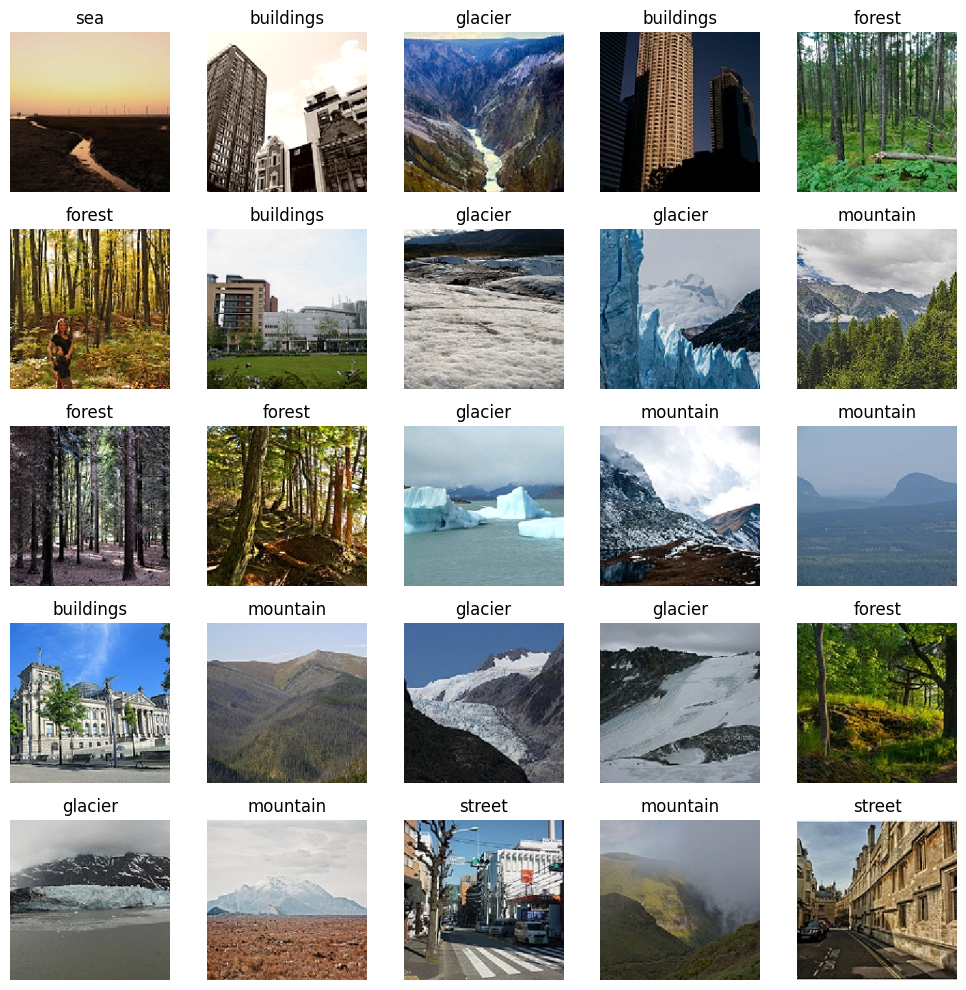

In [5]:
idx_to_class = {v: k for k, v in train_ds.class_indices.items()}

images, labels = next(train_ds) 

plt.figure(figsize=(10,10))
n = min(25, len(images))
for i in range(n):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])

    lab = labels[i]
    if isinstance(lab, np.ndarray):
        lab = np.squeeze(lab)
        if lab.ndim == 0:
            label_idx = int(lab)
        else:
            label_idx = int(np.argmax(lab))
    else:
        label_idx = int(lab)

    plt.title(idx_to_class[label_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

## Örnek Eğitim Verileri
- Bu bölümde eğitim veri setinden örnek görseller çekilip etiketleri ile birlikte gösterilmektedir.
- plt.tight_layout() ve plt.show() komutlarıyla tüm görseller düzgün bir ızgara düzeninde ekrana basılıyor.


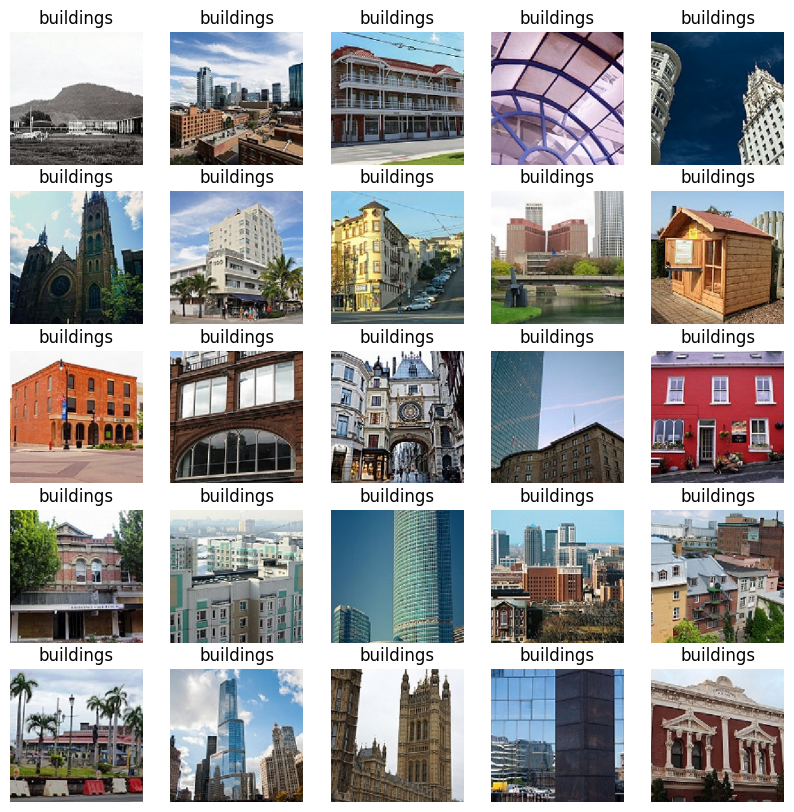

In [6]:
idx_to_class = {v: k for k, v in val_ds.class_indices.items()}

images, labels = next(val_ds)

plt.figure(figsize=(10,10))
n = min(25, len(images))
for i in range(n):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])

    if labels.ndim == 1 or labels.shape[-1] == 1:
        label_idx = int(labels[i])
    else:
        label_idx = int(np.argmax(labels[i]))

    plt.title(idx_to_class[label_idx])
    plt.axis("off")
plt.show()


## Örnek Doğrulama Verileri
- Bu bölümde doğrulama veri setinden örnek görseller çekilip etiketleri ile birlikte gösterilmektedir.
- plt.tight_layout() ve plt.show() komutlarıyla tüm görseller düzgün bir ızgara düzeninde ekrana basılıyor.

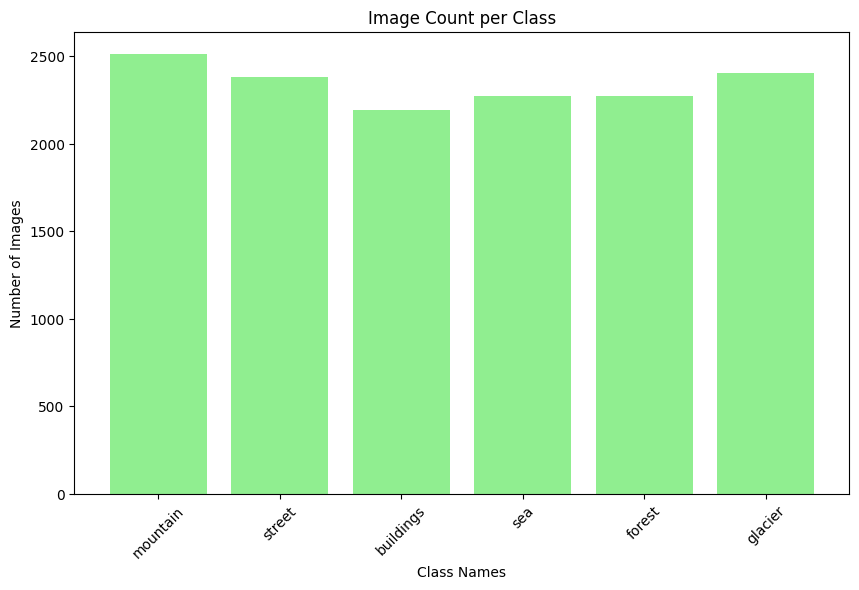

In [7]:
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
        
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

## Eğitim Veri Kümesi Görüntü Verisi Görselleştirme
- Bu adımda eğitim veri kümesinde her sınıfa ait kaç görüntü olduğunu buluyor ve bunu sütun grafiği ile görselleştiriyoruz.

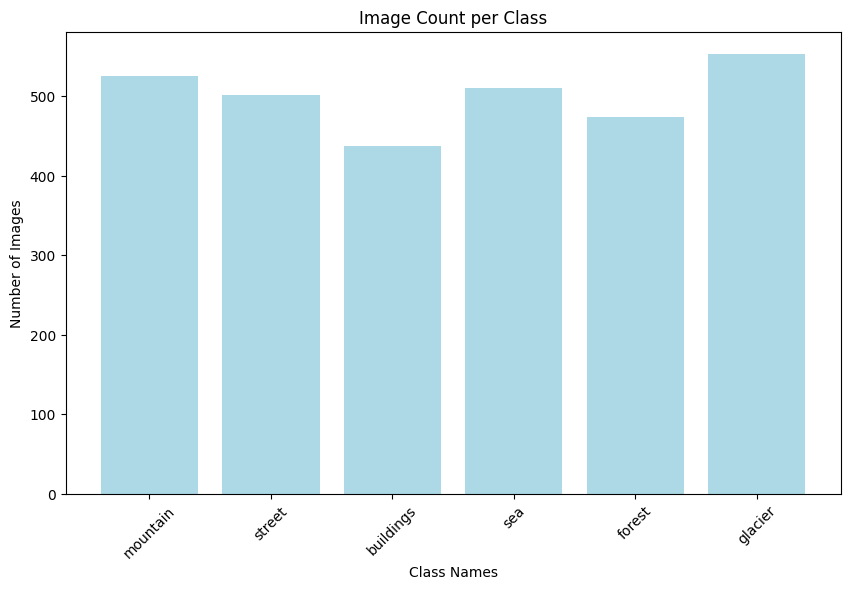

In [8]:
class_counts = {}
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path, class_name)  
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))  
        class_counts[class_name] = num_images  
        
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45) 
plt.show()

## Test Veri Kümesi Görüntü Verisi Görselleştirme
- Bu adımda test veri kümesinde her sınıfa ait kaç görüntü olduğunu buluyor ve bunu sütun grafiği ile görselleştiriyoruz.

In [9]:
model=Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(124,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=len(classes_names),activation='softmax'))

I0000 00:00:1758836713.433039      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758836713.433876      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Model Oluşturma
- Bu adımda sınıflandırma için bir Convolutional Neural Network (CNN) modeli tanımlanıyor.
- Input(shape=(224, 224, 3)): Model 224x224 boyutunda 3 kanallı (RGB) görüntüleri giriş olarak alır.
- Conv2D(32, kernel_size=(5,5), activation='relu'): 32 filtreli 5x5 boyutunda evrişim katmanı.
- MaxPooling2D(2,2): 2x2 boyutunda havuzlama ile boyut küçültme.
- Flatten(): Çıktılar tek boyutlu vektöre dönüştürülüyor.
- Dropout(0.20): %20 oranında dropout uygulanarak aşırı öğrenme (overfitting) engelleniyor.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 124)            │       127,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,270,186 (4.85 MB)

 Trainable params: 1,270,186 (4.85 MB)

 Non-trainable params: 0 (0.00 B)

Bu adım kurulan CNN modelinin yapısını ve her katmandaki parametre sayısını özet halinde gösterir.

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Modelin Derlenmesi (Compile)

- Bu adımda oluşturulan CNN modeli derleniyor.
- Optimizer olarak adam kullanılıyor.
- Sınıflı sınıflandırma problemleri için uygun bie kayıp fonnksiyonu kullanılıyor.
- Modelin performansı doğruluk metriği le takip ediliyor

In [12]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

## Eraly Stopping Mekanizması
- Bu adımda eğitim sürecinde erken durdurma stratejisi tanımlanıyor.
- Doğrulama setindeki doğruluk takp edilir ve 5 epoch boyunca doğrulama iyileşmezse eğitimi durdurur.



In [13]:
history=model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1758836720.370098      87 service.cc:148] XLA service 0x7c3bc8115240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758836720.371786      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758836720.371811      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758836720.911333      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/351 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.1094 - loss: 1.7743   

I0000 00:00:1758836727.961131      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 100s 253ms/step - accuracy: 0.4212 - loss: 1.3367 - val_accuracy: 0.6519 - val_loss: 0.9352
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.6321 - loss: 0.9256 - val_accuracy: 0.7222 - val_loss: 0.7238
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.7198 - loss: 0.7578 - val_accuracy: 0.7343 - val_loss: 0.7004
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.7438 - loss: 0.7062 - val_accuracy: 0.7657 - val_loss: 0.6231
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.7699 - loss: 0.6265 - val_accuracy: 0.8078 - val_loss: 0.5402
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.7986 - loss: 0.5567 - val_accuracy: 0.7939 - val_loss: 0.5626
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.8064 - loss: 0.5390 - val_accuracy: 0.7971 - val_loss: 0.5427
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.8273 - loss: 0.4905 - va

## Modelin Eğitimi
- Bu adımda model, eğitim veri seti üzerinde eğitiliyor
-  Doğrulama seti ile performansı takip ediliyor.

In [14]:
loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8123 - loss: 0.5147
Validation accuracy: 83.10%


## Modelin Doğrulama Setinde Değerlendirilmesi
- Eğitim tamamlandıktan sonra model, doğrulama veri seti üzerinde test edilerek performansı ölçülür.


In [15]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.7918 - loss: 0.5365
Test accuracy: 81.57%


## Modelin Test Setinde Değerlendirilmesi
- Eğitim tamalandıktan  sonra model test veri seti üzerinden test edilerek performansı ölçülür.


In [16]:
raw_preds = model.predict(val_ds, steps=len(val_ds), verbose=0)
y_pred = np.argmax(raw_preds, axis=1)

# ground-truth
ys = []
for i in range(len(val_ds)):
    _, by = val_ds[i]
    if by.ndim == 1 or by.shape[-1] == 1: ys.extend(by.astype(int).ravel())
    else: ys.extend(np.argmax(by, axis=1))
y_true = np.array(ys, dtype=int)

print(classification_report(y_true, y_pred, target_names=classes_names))


              precision    recall  f1-score   support

   buildings       0.84      0.75      0.79       438
      forest       0.96      0.95      0.95       454
     glacier       0.81      0.78      0.80       480
    mountain       0.79      0.81      0.80       502
         sea       0.83      0.79      0.81       454
      street       0.78      0.91      0.84       476

    accuracy                           0.83      2804
   macro avg       0.83      0.83      0.83      2804
weighted avg       0.83      0.83      0.83      2804



## Classification Report
- Bu bölümde modelin doğrulama veri seti üzerindeki sınıflandırma performansı ayrıntılı olarak değerlendirilmektedir.
- Her sınıf için şu metrikler hesaplanır:  
    - **Precision (Kesinlik):** Doğru pozitif tahminlerin tüm pozitif tahminlere oranı.  
    - **Recall (Duyarlılık):** Doğru pozitif tahminlerin gerçek pozitiflere oranı.  
    - **F1-score:** Precision ve Recall’un harmonik ortalaması.  
    - **Support:** Her sınıfa ait örnek sayısı.  

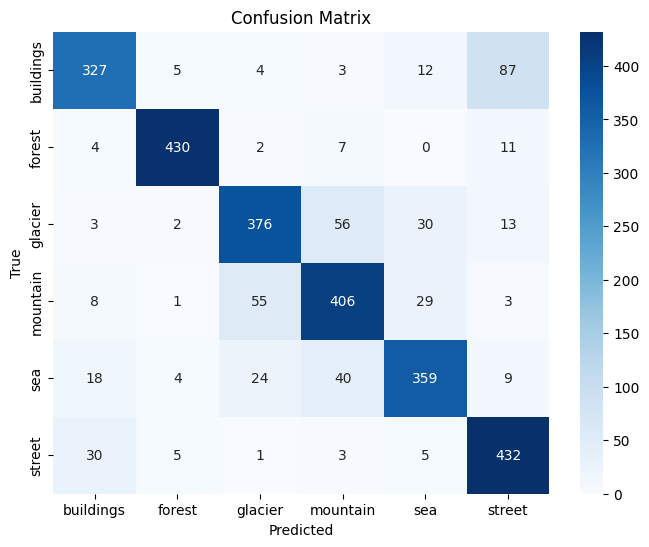

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_names,
            yticklabels=classes_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## Confusion Metrix
Bu bölümde modelin doğrulama seti üzerindeki tahmin performansı, Confusion Matrix ile görselleştirilmektedir.  


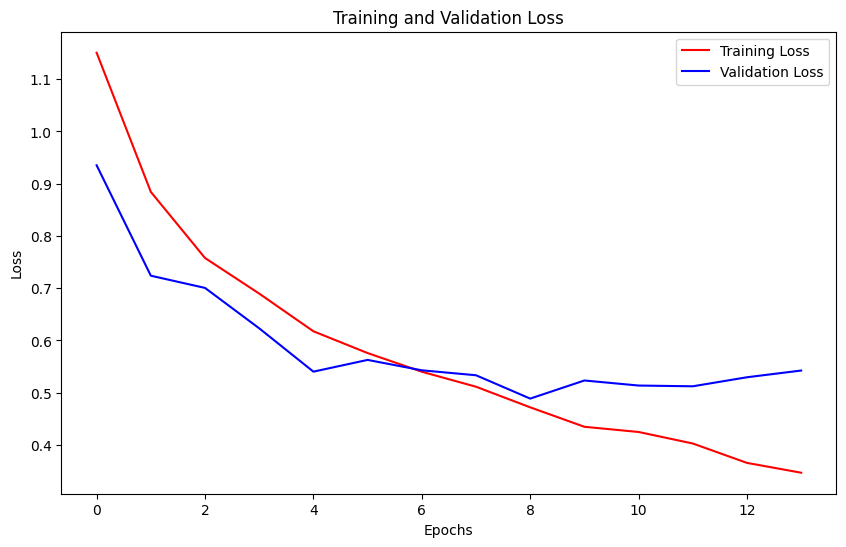

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Eğitim ve Doğrulama Kayıplarının Görselleştirilmesi
- Bu bölümde modelin eğitim süreci boyunca kaydedilen loss (kayıp) değerleri çizdirilmektedir.
- history.history['loss']: Eğitim veri seti üzerindeki kayıp değerleri.
- history.history['val_loss']: Doğrulama veri seti üzerindeki kayıp değerleri.  
- epochs = range(len(loss)): Epoch sayısı kadar bir aralık oluşturuluyor.

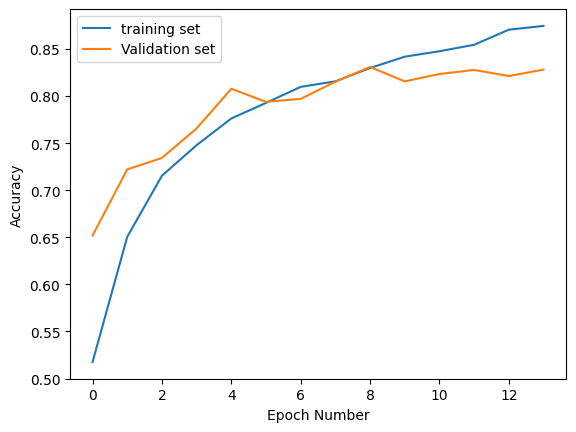

In [19]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='Validation set')
plt.legend()

## Eğitim ve Doğrulama Doğruluklarının Görselleştirilmesi
- Bu bölümde modelin eğitim sürecinde kaydedilen accuracy (doğruluk) değerleri çizdirilmektedir.  



In [20]:
def predict_img(file_name, model):
    img = load_img(file_name, target_size=(224, 224))
    img_array = img_to_array(img)                       
    img_array = np.expand_dims(img_array, axis=0)       
    img_array = img_array / 255.0                       
    # tahmin
    preds = model.predict(img_array)
    class_index = np.argmax(preds, axis=1)[0]
    return class_index, preds[0]

predict_img('/kaggle/input/intel-image-classification/seg_pred/seg_pred/101.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(2,
 array([2.0084715e-04, 6.8552649e-06, 9.2247558e-01, 6.4489193e-02,
        1.2768656e-02, 5.8863134e-05], dtype=float32))

## Tek Bir Görsel Üzerinde Tahmin Yapma
- Bu bölümde eğitimli model kullanılarak tek bir görsel üzerinde sınıf tahmini yapılmaktadır.

In [21]:
def find_last_conv2d(m):
    for layer in reversed(m.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError("Conv2D katmanı bulunamadı.")

last_conv_layer_name = find_last_conv2d(model)
print("Son Conv2D:", last_conv_layer_name)

def load_image_for_model(path, target_size=(224,224)):
    orig_bgr = cv2.imread(path)
    if orig_bgr is None:
        raise FileNotFoundError(f"Görsel bulunamadı: {path}")
    orig = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # Model girişi
    resized = cv2.resize(orig, target_size).astype(np.float32)
    x = resized / 255.0 
    x = np.expand_dims(x, axis=0) 
    return orig, x

def eigen_cam(model, img_batch, last_conv_layer_name):

    conv = model.get_layer(last_conv_layer_name)
    feat_extractor = Model(inputs=model.inputs, outputs=conv.output)

    fmap = feat_extractor(img_batch, training=False).numpy().squeeze()
    H, W, C = fmap.shape

    Z = fmap.reshape(-1, C).astype(np.float64)

    Z -= Z.mean(axis=0, keepdims=True)

    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    principal = Vt[0]

    # ısı haritası
    cam = (Z @ principal).reshape(H, W)

    cam_min, cam_max = cam.min(), cam.max()
    if cam_max - cam_min < 1e-12:
        cam = np.zeros_like(cam, dtype=np.float32)
    else:
        cam = (cam - cam_min) / (cam_max - cam_min)
    return cam

def overlay_heatmap(rgb_img, heatmap, alpha=0.45):
    hm = cv2.resize(heatmap, (rgb_img.shape[1], rgb_img.shape[0]))
    hm_u8 = np.uint8(255 * hm)
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    hm_color = cv2.cvtColor(hm_color, cv2.COLOR_BGR2RGB)
    return cv2.addWeighted(rgb_img, 1 - alpha, hm_color, alpha, 0)



Son Conv2D: conv2d_4


## Eigen-CAM ile Görselleştirme
- Bu bölümde modelin tahminlerinde hangi bölgelerin daha etkili olduğunu anlamak için Eigen-CAM yöntemi uygulanmaktadır.
- find_last_conv2d fonksiyonu ile son convolution katmanının ne olduğu bulunuyor.
- load_image_for_model fonksiyonu ile de görsel eigin-cam için hazırlanıyor.
- eigen_cam fonksiyonu ile de modelin dikkate aldığı bölgeleri temsil eden ısı haritası oluşturulur.
- overlay_heatmap ile de ısı haritası ile görsel belirli bir şeffaflık ile birleştirilir.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tahmin sınıfı: glacier


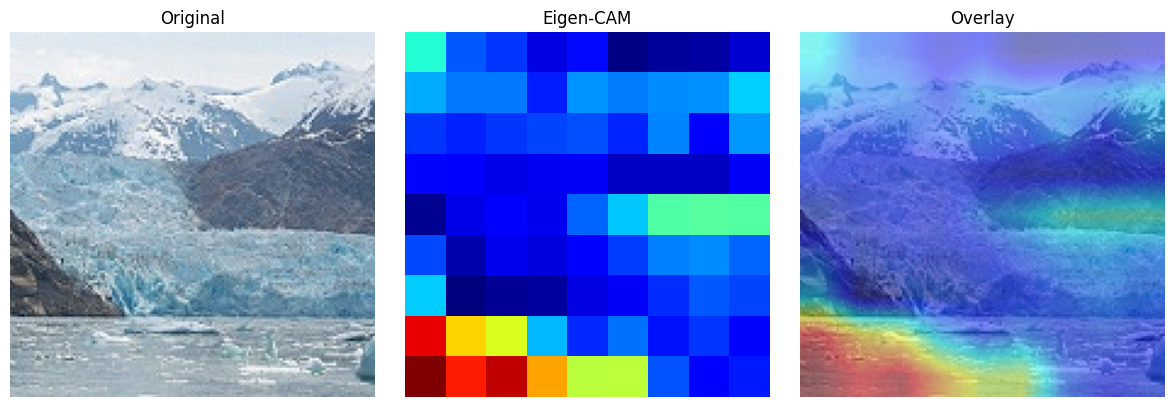

Kaydedildi: eigen_cam_overlay.jpg


In [22]:
img_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/101.jpg"  # istediğin görsel
orig, x = load_image_for_model(img_path, target_size=(224,224))

preds = model.predict(x)
pred_idx = np.argmax(preds[0])
print("Tahmin sınıfı:", classes_names[pred_idx])

# Eigen-CAM
heatmap = eigen_cam(model, x, last_conv_layer_name)
overlay_img = overlay_heatmap(orig, heatmap, alpha=0.45)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(orig); plt.axis('off')
plt.subplot(1,3,2); plt.title("Eigen-CAM"); plt.imshow(heatmap, cmap='jet'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay_img); plt.axis('off')
plt.tight_layout(); plt.show()

cv2.imwrite("eigen_cam_overlay.jpg", cv2.cvtColor(overlay_img, cv2.COLOR_RGB2BGR))
print("Kaydedildi: eigen_cam_overlay.jpg")


## Eigen-CAM Uygulaması
- Bu bölümde Eigen-CAM yöntemi kullanılarak modelin karar verirken hangi bölgelere odaklandığı görselleştirilmektedir.


In [23]:
# Hiperparametre optimizasyonu
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

results = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        # Modeli
        model=Sequential()
        model.add(Input(shape=(224, 224, 3)))
        model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(2,2))
        model.add(Flatten())
        model.add(Dense(units=1024,activation='relu'))
        model.add(Dropout(0.20))
        model.add(Dense(124,activation='relu'))
        model.add(Dropout(0.20))
        model.add(Dense(units=len(classes_names),activation='softmax'))

        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

        # Modelin eğitimi
        history=model.fit(train_ds,validation_data=val_ds,epochs=20,callbacks=[early_stopping])
        # Sonuçlar
        results[f'lr_{lr}_bs_{batch_size}'] = history.history['val_accuracy'][-1]

print("Hiperparametre sonuçları:")
for key, value in results.items():
    print(f"{key}: {value:.4f}")

best_params = max(results, key=results.get)
best_score = results[best_params]

print(f"En iyi kombinasyon: {best_params} -> {best_score:.4f}")

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 126ms/step - accuracy: 0.4295 - loss: 1.3297 - val_accuracy: 0.6141 - val_loss: 0.9317
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.6256 - loss: 0.9394 - val_accuracy: 0.6897 - val_loss: 0.7924
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.6822 - loss: 0.8231 - val_accuracy: 0.6986 - val_loss: 0.7788
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - accuracy: 0.7494 - loss: 0.6692 - val_accuracy: 0.7735 - val_loss: 0.6321
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.7753 - loss: 0.6133 - val_accuracy: 0.7899 - val_loss: 0.5808
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.7896 - loss: 0.5740 - val_accuracy: 0.8078 - val_loss: 0.5268
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.8089 - loss: 0.5195 - val_accuracy: 0.8124 - val_loss: 0.5433
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.8226 - loss: 0

## Hiperparametre Optimizasyonu
- Bu bölümde modelin performansını artırmak için öğrenme oranı (learning rate) ve batch size hiperparametreleri üzerinde denemeler yapılmaktadır.
- model oluşturlur eğitilir ve her seferinde farklı bach size ve learning rate kullanılarak değerlendirilir.
